In [1]:
import numpy as np
import pandas as pd
from dobbel import dobbellogger

In [3]:
dob = dobbellogger()
dob.log(10, 200, 8, 125)
dob.download()
data = dob.datadf

Logging data for 10s
Done! The data is located in self.datadf


In [4]:
def expq(vector, multiplier=1):
    x, y, z = vector[0] * multiplier, vector[1] * multiplier, vector[2]  * multiplier
    absq = (x ** 2 + y ** 2 + z ** 2) ** 1/2
    w = np.cos(absq)
    sinabs = np.sin(absq)
    xq = x * sinabs / absq
    yq = y * sinabs / absq
    zq = z * sinabs / absq
    return np.array([w, xq, yq, zq])

In [5]:
def quat_mul(p, q):
    p0 = p[0]
    q0 = q[0]
    pv = p[1:]
    qv = q[1:]
    out0 = p0 * q0 - np.dot(pv, qv)
    outv = p0 * qv + q0 * pv + np.cross(pv, qv)
    out = np.array([out0, *outv])
    return out

In [6]:
def quaternion_conjugate(q):
    w, x, y, z = q
    return np.array([w, -x, -y, -z])

In [7]:
# Actual Rotation Fuction - Input = Acceleration vector = 1x3 , rotation_quaternion = 1*4
def rotate_vector(vector, rotation_quaternion):
    # Convert the vector to a quaternion
    vector_quaternion = np.concatenate(([0], vector))

    # Calculate the rotated quaternion
    rotated_quaternion = quat_mul(rotation_quaternion, quat_mul(vector_quaternion, quaternion_conjugate(rotation_quaternion)))

    # Extract the rotated vector from the quaternion
    rotated_vector = rotated_quaternion[1:]

    return np.array(rotated_vector)

In [8]:
def remove_nan(df):
    counter = 0
    nan = True
    while nan:
        if not df.loc[counter].isna().any():
            nan = False
        counter += 1
    for i in range(counter - 1):
        df = df.drop(index=i)
    df = df.reset_index(drop=True)
    counter = len(df) - 1
    nan = True
    while nan:
        if not df.loc[counter].isna().any():
            nan = False
        counter -= 1
    maxlen = len(df)
    for i in range(maxlen - 1, counter + 1, -1):
        df = df.drop(index=i)
    df = df.reset_index(drop=True)
    for i in range(len(df)):
        df['timestamp'][i] = df['timestamp'][i] - df['timestamp'][0]
    for i in range(len(df)):
        for column in df.columns:
            if np.isnan(df[column][i]):
                deler = (df['timestamp'][i] - df['timestamp'][i - 1]) / (df['timestamp'][i + 1] - df['timestamp'][i - 1])
                df[column][i] = df[column][i - 1] + deler * (df[column][i + 1] - df[column][i - 1])
    return df

In [9]:
data = remove_nan(data)
data.head(1000)

,timestamp,x_acc,y_acc,z_acc,x_gyro,y_gyro,z_gyro
0,0.0,0.011475,-1.020264,-0.006836,-0.148628,0.392531,-0.735518
1,20.0,0.012695,-1.021973,-0.009033,-0.213415,-0.057165,-0.125762
2,24.0,0.010010,-1.022461,-0.010986,-0.087652,0.575457,0.179116
3,30.0,0.012451,-1.021240,-0.011719,-0.083841,0.464939,-0.003811
4,35.0,0.009521,-1.020996,-0.008301,-0.179116,0.362043,0.110518
...,...,...,...,...,...,...,...
995,4832.0,-0.500488,0.791016,0.245850,-121.852135,21.920732,-124.874237
996,4836.0,-0.548584,0.710205,0.203857,-124.874237,18.628050,-124.874237
997,4842.0,-0.616211,0.692627,0.165771,-124.874237,3.517531,-124.874237
998,4847.0,-0.698975,0.716064,0.149658,-124.798019,-18.807165,-124.874237


In [10]:
def detect_number(arr):
    x, y, z = arr
    print(x, y, z)
    if x < - 0.5 and np.abs(y) < 0.1 and z < -0.5:
        return 1
    elif np.abs(x) < 0.1 and y > 0.8 and np.abs(z) < 0.1:
        return 2
    elif x > 0.5 and np.abs(y) < 0.1 and z < -0.5:
        return 3
    elif x < 0.5 and np.abs(y) < 0.1 and z > -0.5:
        return 4
    elif np.abs(x) < 0.1 and y < -0.8 and np.abs(z) < 0.1:
        return 5
    elif x > 0.5 and np.abs(y) < 0.1 and z > 0.5:
        return 6
    else:
        return 'Could not detect number'

In [11]:
q = np.array([1, 0, 0, 0])
v = np.array([0, 0, 0])
p = np.array([0, 0, 0])
q_list = [q]
p_list = [p]
v_list = [v]
gravDetectTime = 100

arr = np.array([data['x_acc'][:gravDetectTime], data['y_acc'][:gravDetectTime], data['z_acc'][:gravDetectTime]])
mean_grav = np.array([9.81 * sum(arr[0,:]) / len(arr[0, :]), 9.81 * sum(arr[1,:]) / len(arr[1, :]), 9.81 * sum(arr[2,:]) / len(arr[2, :])])

for i in range(gravDetectTime, len(data['timestamp']) - 1):
    dt = (data['timestamp'][i + 1] - data['timestamp'][i]) / 1000
    omega = np.array([data['x_gyro'][i], data['y_gyro'][i], data['z_gyro'][i]])
    expq_omega = expq(omega, 0.5 * dt * np.pi / 180)
    q = quat_mul(q, expq_omega)
    ab = np.array([data['x_acc'][i], data['y_acc'][i], data['z_acc'][i]])
    ab = 9.81 * ab
    an = rotate_vector(ab, q) - mean_grav
    p = p + dt * v + 0.5 * an * dt ** 2 
    v = v + dt * an
    q_list.append(q)
    p_list.append(p)
    v_list.append(v)
    
estimate = pd.DataFrame(columns=['timestamp', 'x_p', 'y_p', 'z_p'])
estimate['timestamp'] = data['timestamp'][gravDetectTime:]

p_array = np.array(p_list)
estimate['x_p'] = p_array[:, 0]
estimate['y_p'] = p_array[:, 1]
estimate['z_p'] = p_array[:, 2]

In [12]:
estimate.head(1000)

,timestamp,x_p,y_p,z_p
100,502.0,0.000000e+00,0.000000e+00,0.000000e+00
101,508.0,-1.873012e-07,3.027993e-07,-4.202772e-07
102,512.0,-5.388200e-07,6.878052e-07,-1.261443e-06
103,518.0,-1.190212e-06,1.841742e-06,-3.014260e-06
104,522.0,-1.591928e-06,2.918688e-06,-4.087265e-06
...,...,...,...,...
1095,5320.0,3.319325e+00,5.946812e+00,-1.230982e+00
1096,5324.0,3.333727e+00,5.993364e+00,-1.236628e+00
1097,5330.0,3.355270e+00,6.063468e+00,-1.244901e+00
1098,5334.0,3.370192e+00,6.110502e+00,-1.250283e+00


In [26]:
quat = q_list[11]
vec = np.array([data.loc[10]['x_acc'], data.loc[10]['y_acc'], data.loc[10]['z_acc']])
print(rotate_vector(vec, quat))

[ 0.01049814 -1.02124196 -0.01378912]


In [23]:
print(data.loc[10]['x_acc'], data.loc[10]['y_acc'], data.loc[10]['z_acc'])

0.010498046875 -1.021240234375 -0.013916015625


In [25]:
print(mean_grav / 9.81)

[ 0.01107096 -1.0210022  -0.01151449]


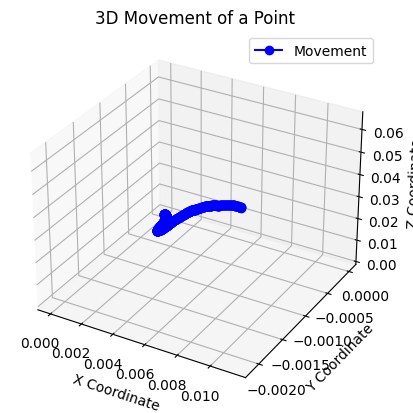

In [15]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Example data: Replace these with your actual lists of coordinates
x_positions = p_array[:500, 0]
y_positions = p_array[:500, 1]
z_positions = p_array[:500, 2]

# Create a new figure for the 3D plot
fig = plt.figure()

# Add a 3D subplot
ax = fig.add_subplot(111, projection='3d')

# Plot the movement of the point
ax.plot(x_positions, y_positions, z_positions, marker='o', linestyle='-', color='b', label='Movement')

# Set labels for each axis
ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')
ax.set_zlabel('Z Coordinate')

# Set a title
ax.set_title('3D Movement of a Point')

# Add a legend
ax.legend()

# Show the plot
plt.show()


In [17]:
data.to_csv('dobbeldata')